# QLearning experiment runner

In [1]:
%%capture
!pip install tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import namedtuple

from q_maze import QMaze, Action
from fei_e_greedy_policy import EGreedyPolicy
from fei_qlearning import QLearning

from typing import Tuple

## Instantiate QMaze and EGreedyPolicy

In [14]:
qm = QMaze(30)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.5, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [15]:
qm.display()

X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X 
X X . . . X X . A . X X . . . X X . . . . . . X . X X . . X 
X . . X . . . . X X X X X . X X X . X X X X X X . X X . X X 
X X X X X X X . X X . X X . . X . . . . X X . . . . . . . X 
X . X . . X X . . X . X X . X X . X X . . X X X . X X X X X 
X . X . X X X X . . . X . . X . . X X X X X . . . . X X X X 
X . . . X X . . . X X X . X X . X X . X . X . X X . . . . X 
X . X X X X X X . . . X . X X . . . . . . . . . X X X X X X 
X . X X . . . . . X X X . . X X . X X X . X X . X X X . . X 
X . . X . X X X . . . X X . X X . . X X . . X X X . . . X X 
X . X X . X X . . X . . . . . . . X X X X X X X X . X X X X 
X . . X X X . . X X X . X . X . X X . X X X . . . . . X . X 
X X . . X . . X X X X X X X X X X . . . . X X X X . X X . X 
X X X . X X . X . X . X . X . X X . X X X X . . . . . . . X 
X . . . . . . X . . . . . . . . . . . . . X X X X . X X X X 
X X X . X . X X . X X X . X X X X . X X X X X . . . . X . X 
X . X X X . X X . . X X 

## One iteration to check policy is working with QLearning

18862


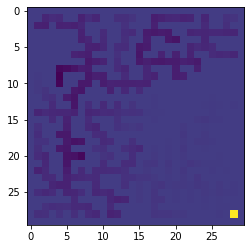

In [16]:
done = False
total_reward = 0

while not done:
    action = eg_policy(state, ql.q_value_store)
    next_state, reward, done = qm.step(action)

    next_action = eg_policy(next_state, ql.q_value_store)
    
    action_index = action.value.index
    
    ql.update_q_values(
        current_state=state,
        next_action=action_index,
        next_reward=reward,
        next_state=next_state
    )

    eg_policy.update_epsilon()
    state = next_state
    total_reward += reward

print(qm.turns_elapsed)
vals = ql.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()))
plt.colorbar()
plt.show()

## Now do it nicely for more episodes

In [7]:
Results = namedtuple("Results", "all_rewards, max_reward, mean_reward, var_reward, all_turns_elapsed, max_turns_elapsed, mean_turns_elapsed, var_turns_elapsed, mean_ending_epsilon")

In [8]:
# Transfer spike code to a nice function
def train_ql_for_one_episode(environment: QMaze, q_learning_method: QLearning, policy: EGreedyPolicy) -> Tuple[int, int, float]:
    state = environment.reset()
    done = False
    total_reward = 0

    while not done:
        action = policy(state, q_learning_method.q_value_store)
        next_state, reward, done = environment.step(action)

        next_action = policy(next_state, q_learning_method.q_value_store)
        
        action_index = action.value.index
        
        q_learning_method.update_q_values(
            current_state=state,
            next_action=action_index,
            next_reward=reward,
            next_state=next_state
        )

        policy.update_epsilon()
        state = next_state
        total_reward += reward

    return total_reward, environment.turns_elapsed, policy.epsilon

In [9]:
def run_ql_experiments(environment: QMaze, policy: EGreedyPolicy, q_learning_method: QLearning, num_exp: int) -> Results:
    all_rewards = []
    all_turns_elapsed = []
    all_ending_epsilon = []

    for _ in range(num_exp):

        final_reward, final_turns_elapsed, final_epsilon = train_ql_for_one_episode(environment=environment, policy=policy, q_learning_method=q_learning_method)

        # Record some information
        all_rewards.append(final_reward)
        all_turns_elapsed.append(final_turns_elapsed)
        all_ending_epsilon.append(final_epsilon)

    
    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards)
    var_reward = np.std(all_rewards)

    max_turns_elapsed = max(all_turns_elapsed)
    mean_turns_elapsed = np.mean(all_turns_elapsed)
    var_turns_elapsed = np.std(all_turns_elapsed)

    mean_ending_epsilon = np.mean(all_ending_epsilon)
    # policy.reset()

    return Results(all_rewards, max_reward, mean_reward, var_reward, all_turns_elapsed, max_turns_elapsed, mean_turns_elapsed, var_turns_elapsed, mean_ending_epsilon)


In [10]:
qm = QMaze(30)
eg_policy = EGreedyPolicy(epsilon=0.6, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)
num_runs = tqdm(range(100))

# Create structure to store data:
all_results = []

for run in num_runs:

    if (episode % 10) == 0:
        results = run_ql_experiments(environment=qm, policy=eg_policy, q_learning_method=ql, num_exp=150)
        print(f"Run: {run}, ending epsilon: {eg_policy.epsilon}, mean reward: {results.mean_reward}, std reward: {results.var_reward}")
        all_results.append(results)

100%|██████████| 50/50 [02:12<00:00,  2.65s/it]Episode: 40, ending epsilon: 0.0900567811781995, mean reward: -2447.693333333333, std reward: 6061.375063956657



X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X 
X X . . . X X . . . X X . . . X X . . . . . . X . X X A . X 
X . . X . . . . X X X X X . X X X . X X X X X X . X X . X X 
X X X X X X X . X X . X X . . X . . . . X X . . . . . . . X 
X . X . . X X . . X . X X . X X . X X . . X X X . X X X X X 
X . X . X X X X . . . X . . X . . X X X X X . . . . X X X X 
X . . . X X . . . X X X . X X . X X . X . X . X X . . . . X 
X . X X X X X X . . . X . X X . . . . . . . . . X X X X X X 
X . X X . . . . . X X X . . X X . X X X . X X . X X X . . X 
X . . X . X X X . . . X X . X X . . X X . . X X X . . . X X 
X . X X . X X . . X . . . . . . . X X X X X X X X . X X X X 
X . . X X X . . X X X . X . X . X X . X X X . . . . . X . X 
X X . . X . . X X X X X X X X X X . . . . X X X X . X X . X 
X X X . X X . X . X . X . X . X X . X X X X . . . . . . . X 
X . . . . . . X . . . . . . . . . . . . . X X X X . X X X X 
X X X . X . X X . X X X . X X X X . X X X X X . . . . X . X 
X . X X X . X X . . X X 

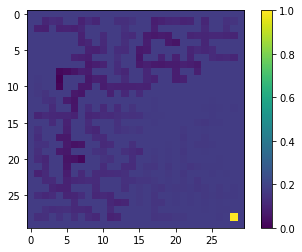

In [29]:
qm.reset()
qm.display()
results_vals = ql.display_q_values()
plt.imshow((results_vals - results_vals.min())/(results_vals.max() - results_vals.min()), cmap="viridis")
plt.colorbar()
plt.show()

In [30]:
results_df = pd.DataFrame(all_results)
results_df.head(10)

,all_rewards,max_reward,mean_reward,var_reward,all_turns_elapsed,max_turns_elapsed,mean_turns_elapsed,var_turns_elapsed,mean_ending_epsilon
0,"[-59032, -120265, -132060, -97017, -51505, -36...",-1123,-18872.093333,21505.846449,"[13657, 28117, 30860, 22743, 12038, 8681, 1252...",30860,4762.013333,5033.960283,0.090057
1,"[-26456, -4001, -13914, -17788, -12595, -4889,...",407,-6319.313333,7606.996564,"[6896, 1268, 3804, 4730, 3528, 1522, 4585, 872...",12214,1870.366667,1948.875948,0.090057
2,"[-2198, -1966, -10894, -6538, -1238, -955, -11...",501,-3535.680000,4307.951687,"[802, 756, 3180, 2006, 581, 464, 277, 698, 390...",4654,1202.700000,1164.400932,0.090057
3,"[-20969, -1407, 406, 131, 375, 574, -3912, 148...",613,-2511.886667,4576.043761,"[5869, 631, 151, 196, 160, 111, 1288, 203, 328...",6084,944.780000,1238.559544,0.090057
4,"[-561, -1226, -2958, -265, 234, 421, 352, -580...",605,-2447.693333,6061.375064,"[429, 630, 1071, 336, 191, 140, 154, 1925, 249...",11924,957.753333,1733.155950,0.090057


## Test QMaze number of steps for different environment sizes

In [34]:
test_size_envs = range(5, 100)

for size_env in test_size_envs:
        test_qm = QMaze()
        test_eg_policy = EGreedyPolicy(epsilon=0.6, decay=0.9)
        test_ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)
        _, final_turns_elapsed, _ = train_ql_for_one_episode(environment=test_qm, policy=test_eg_policy, q_learning_method=test_ql)
        print(f"Size of env: {size_env}, final_turns_elapsed: {final_turns_elapsed}")

Size of env: 5, final_turns_elapsed: 80
Size of env: 6, final_turns_elapsed: 29
Size of env: 7, final_turns_elapsed: 64
Size of env: 8, final_turns_elapsed: 5
Size of env: 9, final_turns_elapsed: 23
Size of env: 10, final_turns_elapsed: 71
Size of env: 11, final_turns_elapsed: 9
Size of env: 12, final_turns_elapsed: 24
Size of env: 13, final_turns_elapsed: 41
Size of env: 14, final_turns_elapsed: 48
Size of env: 15, final_turns_elapsed: 45
Size of env: 16, final_turns_elapsed: 41
Size of env: 17, final_turns_elapsed: 23
Size of env: 18, final_turns_elapsed: 23
Size of env: 19, final_turns_elapsed: 8
Size of env: 20, final_turns_elapsed: 6
Size of env: 21, final_turns_elapsed: 13
Size of env: 22, final_turns_elapsed: 19
Size of env: 23, final_turns_elapsed: 22
Size of env: 24, final_turns_elapsed: 7
Size of env: 25, final_turns_elapsed: 31
Size of env: 26, final_turns_elapsed: 11
Size of env: 27, final_turns_elapsed: 44
Size of env: 28, final_turns_elapsed: 59
Size of env: 29, final_tur

In [15]:
epsilon_list = [0.5, 0.7, 0.9]
gamma_list = [0.5, 0.7, 0.9]
env_size_list = [10, 20, 30, 40, 50]

# mean_reward = []
# std_reward = []
    
# for size_envir in range(5,50,5):

#     # heuristics
#     n_improvement_steps = size_envir
#     n_steps_policy_eval = 10
    
#     total_rewards = []

#     for n_envir in range(n_environments_per_size):

#         dungeon = DungeonDP(size_envir)
#         policy = Policy(dungeon, gamma)
        
#         for n_improvements in range(n_improvement_steps):
    
#             policy.policy_iteration(n_steps_policy_eval)

#         all_total_rewards, _, _, _ = run_experiments(dungeon, policy, n_runs_per_environments)

#         total_rewards += all_total_rewards

#     mean_reward.append( np.mean(total_rewards) )
#     std_reward.append( np.std(total_rewards) )

# mean_reward = np.asarray(mean_reward)
# std_reward = np.asarray(std_reward)

# plt.plot(range(5, 50, 5), mean_reward, 'or')
# plt.plot(range(5, 50, 5), mean_reward, color = 'r')
# plt.fill_between(range(5, 50, 5), mean_reward - std_reward/2, mean_reward + std_reward/2,
#              color='r', alpha=0.2)

# plt.xlabel('Environment size')
# plt.ylabel('Average reward')

# plt.show()